In [4]:
!pip install mxnet-cu101

In [5]:
import os

import mxnet as mx
import numpy as np
import torch
from mxnet import gluon

import pandas as pd
import matplotlib.pyplot as plt


In [6]:
# sample coords contains a sample of coordinates for red and blue
df = pd.read_csv('sample_coords.csv', header=None)
df.columns=['x1','y1', 'x2','y2']
print(df.shape)
x_bounds = [min(min(df.x1), min(df.x2)) , max(max(df.x1), max(df.x2))]
y_bounds = [min(min(df.y1), min(df.y2)) , max(max(df.y1), max(df.y2))]
print(x_bounds)
print(y_bounds)
df.head()

(2307, 4)
[-120.0, 62.0]
[-120.0, 118.5]


,x1,y1,x2,y2
0,-57.714286,80.142857,-62.125000,-83.500000
1,-59.333333,59.833333,-63.250000,-62.125000
2,-66.200000,42.000000,-65.100000,-46.200000
3,-59.333333,31.000000,-64.142857,-29.428571
4,-60.833333,14.166667,-59.444444,-13.000000


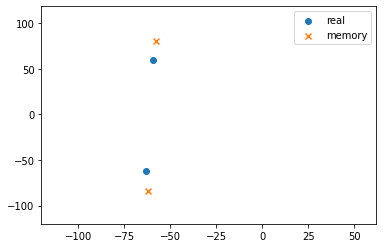

In [7]:
def plot_coords(real_coords, memory_coords, save_as=None):  
  plt.figure()
  x = [real_coords[0], real_coords[2]]
  y = [real_coords[1], real_coords[3]]
  plt.scatter(x, y, label='real')
  x = [memory_coords[0], memory_coords[2]]
  y = [memory_coords[1], memory_coords[3]]
  plt.scatter(x, y, label='memory', marker='x')

  plt.xlim(x_bounds)
  plt.ylim(y_bounds)
  plt.legend()
  
  if save_as:
    plt.savefig(save_as)
    plt.close()
# test plot function
plot_coords(df.iloc[1], df.iloc[0])

In [27]:
class autoencoder(gluon.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Dense(2, in_units = 4))

            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(4, in_units =2))
                
    def encode(self, x):
      return self.encoder(x)

    def decode(self, x):
      return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [10]:
num_epochs = 200
batch_size = 128
learning_rate = 1e-3
ctx = mx.cpu()

In [11]:
# convert dataframe to gluon dataset
arr = df.to_numpy(dtype=np.float32)
dataset = mx.gluon.data.dataset.ArrayDataset(arr)

dataloader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
model = autoencoder()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()

optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    for data in dataloader:
        with mx.autograd.record():
            output = model(data)
            loss = criterion(output, data)
        loss.backward()
        optimizer.step(batch_size)
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += batch_size
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))
    if epoch % 25 == 0:
      #data
      real = data.asnumpy().flatten()
      memory = output.asnumpy().flatten()
      plot_coords(real, memory, './mlp_img/{}_autoencoder.png'.format(epoch))
model.save_parameters('./simple_autoencoder.params')

epoch [1/200], loss:3539.9113
epoch [2/200], loss:3334.8861
epoch [3/200], loss:3156.1140
epoch [4/200], loss:2994.2276
epoch [5/200], loss:2845.9875
epoch [6/200], loss:2706.1571
epoch [7/200], loss:2572.9610
epoch [8/200], loss:2444.4105
epoch [9/200], loss:2319.2567
epoch [10/200], loss:2198.5430
epoch [11/200], loss:2080.5215
epoch [12/200], loss:1968.1102
epoch [13/200], loss:1860.0713
epoch [14/200], loss:1759.1825
epoch [15/200], loss:1664.7799
epoch [16/200], loss:1578.6140
epoch [17/200], loss:1498.8278
epoch [18/200], loss:1426.9756
epoch [19/200], loss:1362.0492
epoch [20/200], loss:1303.4843
epoch [21/200], loss:1250.0906
epoch [22/200], loss:1201.9806
epoch [23/200], loss:1157.8445
epoch [24/200], loss:1118.2186
epoch [25/200], loss:1081.6715
epoch [26/200], loss:1048.6490
epoch [27/200], loss:1018.3628
epoch [28/200], loss:990.8240
epoch [29/200], loss:965.6399
epoch [30/200], loss:942.6431
epoch [31/200], loss:921.4690
epoch [32/200], loss:902.0629
epoch [33/200], loss:8

In [13]:
# test network
init_state = mx.nd.array([df.iloc[0]])
print(init_state)
encoding = model.encode(init_state)
print(encoding)
decoding = model.decode(encoding)
print(decoding)


[[-57.714287  80.14286  -62.125    -83.5     ]]
<NDArray 1x4 @cpu(0)>

[[41.17985   -7.6087823]]
<NDArray 1x2 @cpu(0)>

[[-42.623146 -27.492971 -44.615887 -40.580906]]
<NDArray 1x4 @cpu(0)>


In [14]:
# test loading the model
model2 = autoencoder()
model2.load_parameters('./simple_autoencoder.params', ctx=ctx)

# test network
init_state = mx.nd.array([df.iloc[0]])
print(init_state)
encoding = model2.encode(init_state)
print(encoding)
decoding = model2.decode(encoding)
print(decoding)


[[-57.714287  80.14286  -62.125    -83.5     ]]
<NDArray 1x4 @cpu(0)>

[[41.17985   -7.6087823]]
<NDArray 1x2 @cpu(0)>

[[-42.623146 -27.492971 -44.615887 -40.580906]]
<NDArray 1x4 @cpu(0)>
